# **Training MLP Network**

# **2-1 Dataset**

In [1]:
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from itertools import cycle
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install unrar
!unrar x './drive/MyDrive/NN_HW2_Face_Emotion.rar';

Streaming output truncated to the last 5000 lines.
Extracting  TRAIN/fear/image0000694.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000701.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000777.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000808.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000815.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000842.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000843.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0000915.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0001001.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0001038.jpg                                   24%  OK 
Extracting  TRAIN/fear/image0

In [6]:
train_datagen = ImageDataGenerator(
        rescale = 1/255.0,
        rotation_range = 20,
        zoom_range = 0,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0,
        horizontal_flip = True,
        fill_mode = "nearest",
        validation_split = 0.2)

tune_datagen = ImageDataGenerator(
        rescale = 1/255.0,
        rotation_range = 20,
        zoom_range = 0,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0,
        horizontal_flip = True,
        fill_mode = "nearest",
        validation_split = 0.2)

train_DS = train_datagen.flow_from_directory(
    directory="TRAIN",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=250,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42)

validation1_DS = train_datagen.flow_from_directory(
    directory="TRAIN",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=250,
    class_mode="categorical",
    subset='validation',
    shuffle=False,
    seed=42)

tune_DS = tune_datagen.flow_from_directory(
    directory="TUNE",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=250,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42)

validation2_DS = tune_datagen.flow_from_directory(
    directory="TUNE",
    target_size = (128, 128),
    color_mode="rgb",
    batch_size=250,
    class_mode="categorical",
    subset='validation',
    shuffle=False,
    seed=42)

Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 1280 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


# **2-2 Samples**

In [7]:
labs = []
imags = []
i = 0
while len(labs) < 8:
     if (np.where((train_DS[0][1][i]) == 1)[0][0] in labs):
          i += 1
          continue
     imags.append(train_DS[0][0][i])
     labs.append(np.where((train_DS[0][1][i]) == 1)[0][0])
     i += 1

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}


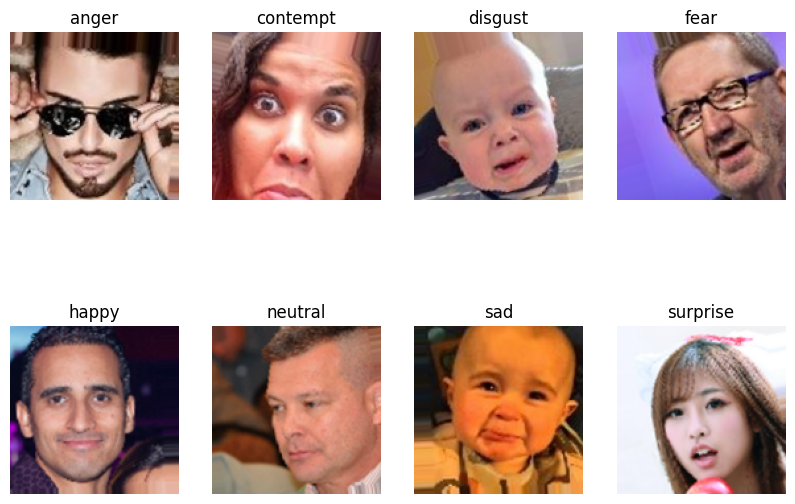

In [8]:
class_names = train_DS.class_indices
print(class_names)

fig = plt.figure(figsize=(10, 7))

for images, labels in zip(imags, labs):
    fig.add_subplot(2, 4, int(labels)+1)
    plt.imshow(images)
    plt.title(list(class_names.keys())[int(labels)])
    plt.axis("off")

In [9]:
train_DS.reset()

# **2-3 Alexnet model**

In [10]:
def mobilnet_block (x, filters, strides):

    x = tf.keras.layers.DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    return x

In [11]:
MobileNet_baseModel = tf.keras.Sequential([

    # CONV 1
    tf.keras.layers.Conv2D(filters=32, input_shape=(128,128,3), kernel_size=(3,3), strides=(2,2), padding="same"),  #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 1
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    tf.keras.layers.SeparableConv2D(filters=64, input_shape=(64,64,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 2
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=128, input_shape=(64,64,3), kernel_size=(3,3), strides=(2,2), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 3
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=128, input_shape=(32,32,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 4
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=256, input_shape=(32,32,3), kernel_size=(3,3), strides=(2,2), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 5
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=256, input_shape=(16,16,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 6
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=512, input_shape=(16,16,3), kernel_size=(3,3), strides=(2,2), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 7
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=512, input_shape=(8,8,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 8
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=512, input_shape=(8,8,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 9
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=512, input_shape=(8,8,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 10
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=512, input_shape=(8,8,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 11
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=512, input_shape=(8,8,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 12
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(2,2), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=1024, input_shape=(8,8,3), kernel_size=(3,3), strides=(2,2), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    # DCONV 13
    # tf.keras.layers.DepthwiseConv2D(kernel_size=(3,3), strides=(1,1), padding='same'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),

    # tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding="same"),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.ReLU(),
    tf.keras.layers.SeparableConv2D(filters=1024, input_shape=(4,4,3), kernel_size=(3,3), strides=(1,1), padding="same"), #   activation="relu"
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    #GlobAvgPooling
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dropout
    tf.keras.layers.GaussianDropout(0.3),

])

In [12]:
# updatable plot

class PlotParams(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.i += 1

        clear_output(wait=True)
        plt.subplot(2,1,1)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.subplot(2,1,2)
        plt.plot(self.x, self.acc, label="accuracy")
        plt.legend()
        plt.show();

plot_params = PlotParams()

In [13]:
MobileNet_headModel = MobileNet_baseModel.output
MobileNet_headModel = tf.keras.layers.Dense(8) (MobileNet_headModel)
MobileNet_headModel = tf.keras.layers.Softmax() (MobileNet_headModel)

MobileNet_Model = tf.keras.Model(inputs=MobileNet_baseModel.input, outputs=MobileNet_headModel)

MobileNet_Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 separable_conv2d (Separabl  (None, 64, 64, 64)        2400      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256   

# **2-4 Training**

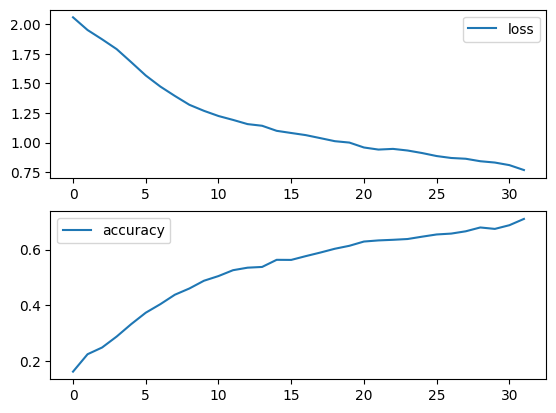

26/26 [==============================] - 34s 1s/step - loss: 0.7672 - accuracy: 0.7106


In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, weight_decay=1e-8)
MobileNet_Model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
MobileNet_Model.fit(train_DS, epochs=32, callbacks=[plot_params])

In [15]:
validation1_DS.reset()
MobileNet_Model.evaluate(validation1_DS)

7/7 [==============================] - 8s 1s/step - loss: 2.3063 - accuracy: 0.4437


[2.306302785873413, 0.4437499940395355]

# **2-5 Fine-Tuning**

In [16]:
train_DS.reset()
tune_DS.reset()

i = 0
for layer in MobileNet_baseModel.layers:
	layer.trainable = False
	i+=1
	if (i>=45):
		break

In [17]:
MobileNet_regModel = MobileNet_baseModel.output
MobileNet_regModel = tf.keras.layers.Dense(8) (MobileNet_regModel)
MobileNet_regModel = tf.keras.layers.Softmax() (MobileNet_regModel)

MobileNet_tuneModel = tf.keras.Model(inputs=MobileNet_baseModel.input, outputs=MobileNet_regModel)

MobileNet_tuneModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 separable_conv2d (Separabl  (None, 64, 64, 64)        2400      
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256 

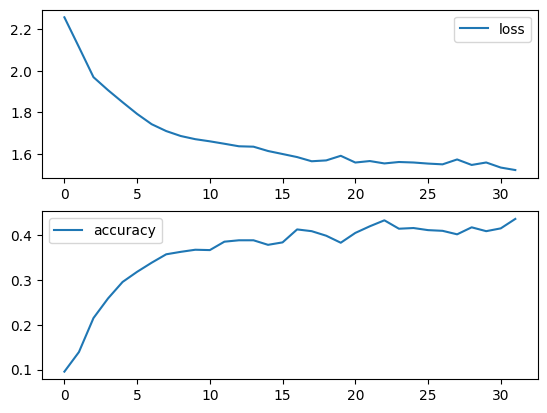

6/6 [==============================] - 7s 1s/step - loss: 1.5217 - accuracy: 0.4359


In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-8, weight_decay=1e-8)
MobileNet_tuneModel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
MobileNet_tuneModel.fit(tune_DS, epochs=32, callbacks=[plot_params])

# **2-6 Evaluation**

In [19]:
validation2_DS.reset()
MobileNet_tuneModel.evaluate(validation2_DS)
validation2_DS.reset()
y_pred = MobileNet_tuneModel.predict(validation2_DS)

2/2 [==============================] - 2s 292ms/step


In [20]:
y_pred = tf.one_hot(tf.argmax(y_pred, axis=1), depth = 8)

In [21]:
y_tune = np.concatenate((validation2_DS[0][1],validation2_DS[1][1]), axis = 0)

In [22]:
y_pred_enc = np.argmax(y_pred, axis=1)
y_tune_enc = np.argmax(y_tune, axis=1)

In [36]:
print('precision, recall,   f1-score')
print(metrics.precision_recall_fscore_support(y_tune_enc, y_pred_enc, average='micro', warn_for=('precision', 'recall', 'f-score'), zero_division='warn'))
print('------------------------------------------------------')
print(metrics.classification_report(y_tune_enc, y_pred_enc))

precision, recall,   f1-score
(0.484375, 0.484375, 0.484375, None)
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.46      0.33      0.38        40
           1       0.65      0.55      0.59        40
           2       0.38      0.45      0.41        40
           3       0.40      0.42      0.41        40
           4       0.60      0.90      0.72        40
           5       0.43      0.53      0.47        40
           6       0.48      0.38      0.42        40
           7       0.45      0.33      0.38        40

    accuracy                           0.48       320
   macro avg       0.48      0.48      0.47       320
weighted avg       0.48      0.48      0.47       320



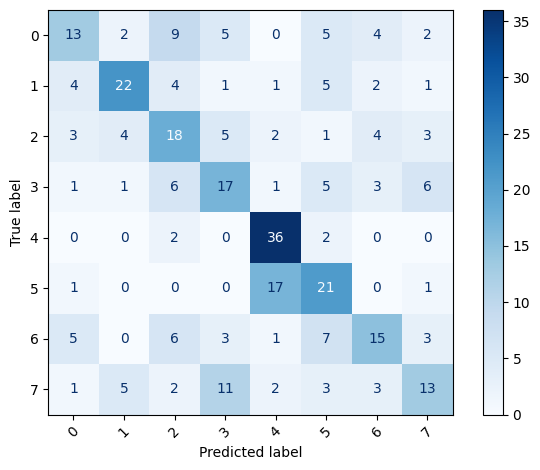

In [24]:
confusion_matrix = confusion_matrix(y_tune_enc, y_pred_enc)
target_names = ["0", "1", "2", "3", "4", "5", "6", "7"]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.tight_layout()

class 0 f1 score
0.6544631838749485
class 0 precision score
0.6859099804305284
class 0 recall score
0.6357142857142857


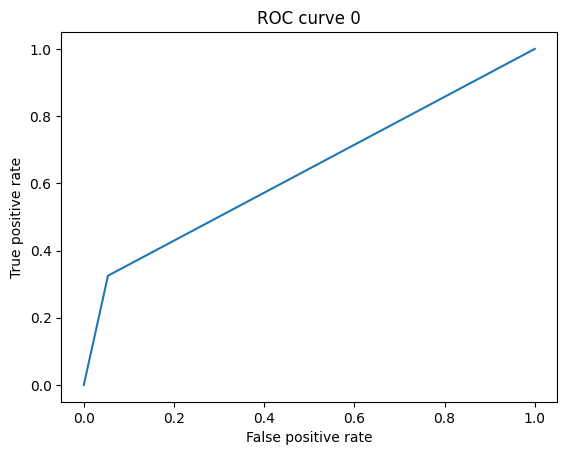

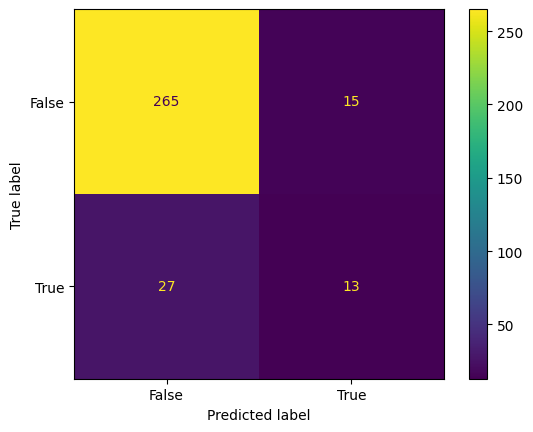

In [25]:
y_pred0 = tf.argmax(y_pred, axis=1) == 0
y_tune0 = tf.argmax(y_tune, axis=1) == 0
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_tune0, y_pred0)
auc_rf0 = metrics.auc(fpr0, tpr0)
plt.plot(fpr0, tpr0, label='Keras (area = {:.3f})'.format(auc_rf0))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 0')

print("class 0 f1 score")
print(metrics.f1_score(y_tune0, y_pred0, average="macro"))
print("class 0 precision score")
print(metrics.precision_score(y_tune0, y_pred0, average="macro"))
print("class 0 recall score")
print(metrics.recall_score(y_tune0, y_pred0, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune0, y_pred0)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 1 f1 score
0.7707955305128451
class 1 precision score
0.7920608802961744
class 1 recall score
0.7535714285714286


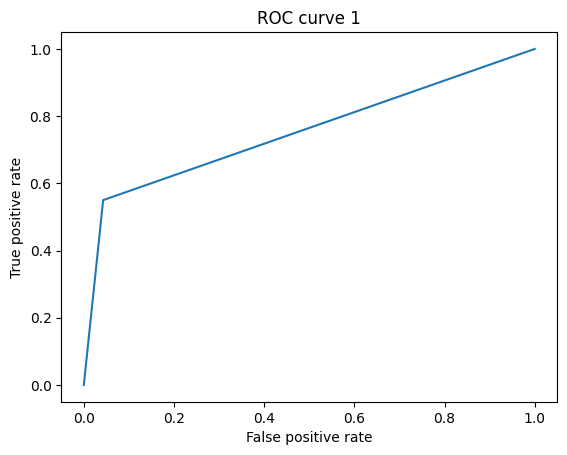

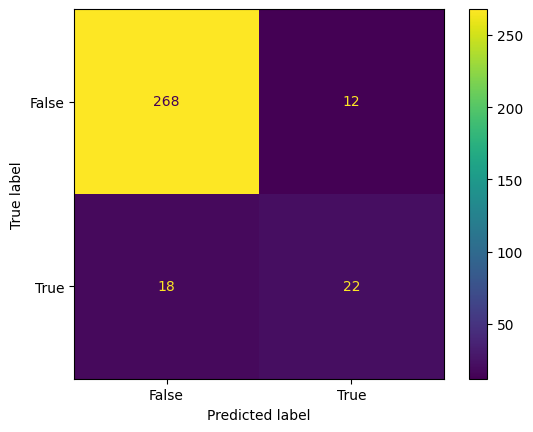

In [26]:
y_pred1 = tf.argmax(y_pred, axis=1) == 1
y_tune1 = tf.argmax(y_tune, axis=1) == 1
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_tune1, y_pred1)
auc_rf1 = metrics.auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 1')

print("class 1 f1 score")
print(metrics.f1_score(y_tune1, y_pred1, average="macro"))
print("class 1 precision score")
print(metrics.precision_score(y_tune1, y_pred1, average="macro"))
print("class 1 recall score")
print(metrics.recall_score(y_tune1, y_pred1, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune1, y_pred1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 2 f1 score
0.660784435991769
class 2 precision score
0.6511963214090873
class 2 recall score
0.6732142857142858


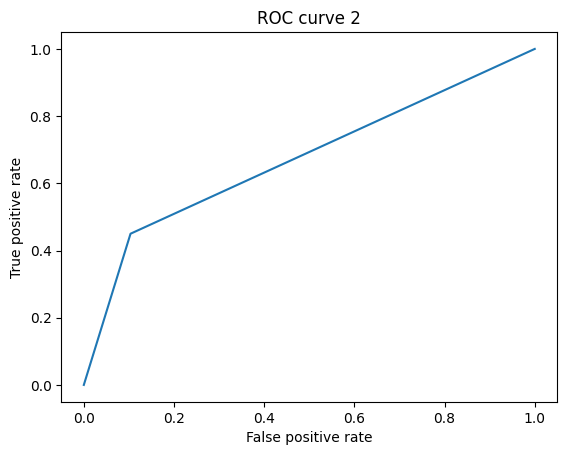

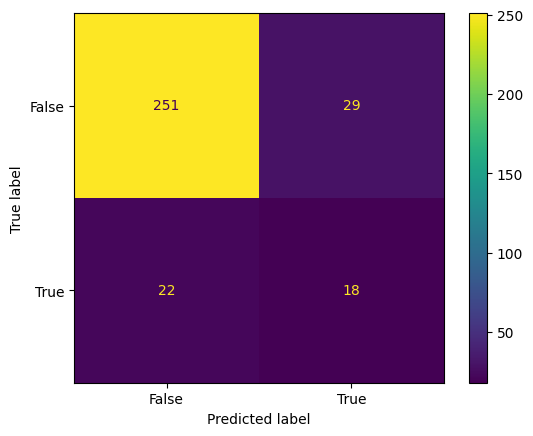

In [27]:
y_pred2 = tf.argmax(y_pred, axis=1) == 2
y_tune2 = tf.argmax(y_tune, axis=1) == 2
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_tune2, y_pred2)
auc_rf2 = metrics.auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 2')

print("class 2 f1 score")
print(metrics.f1_score(y_tune2, y_pred2, average="macro"))
print("class 2 precision score")
print(metrics.precision_score(y_tune2, y_pred2, average="macro"))
print("class 2 recall score")
print(metrics.recall_score(y_tune2, y_pred2, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune2, y_pred2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 3 f1 score
0.6643063204825597
class 3 precision score
0.6610140459061322
class 3 recall score
0.6678571428571428


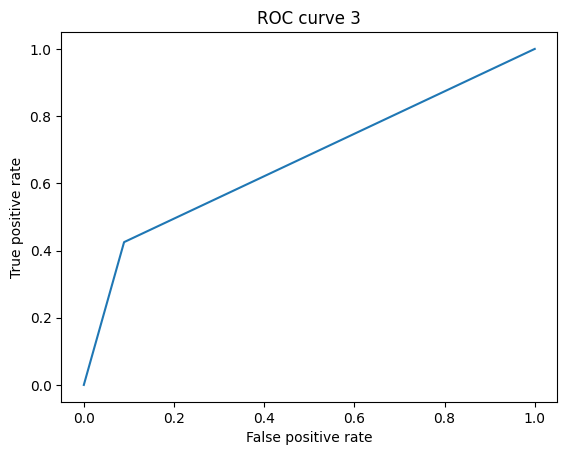

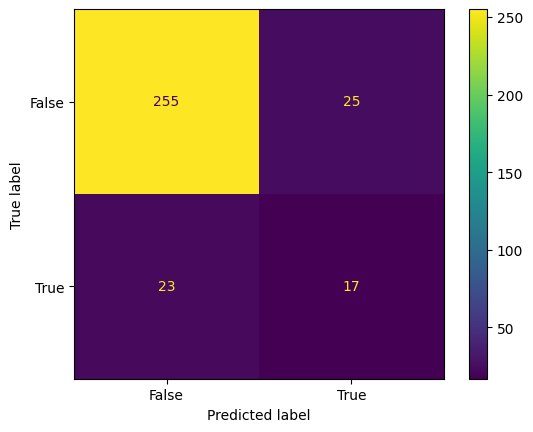

In [28]:
y_pred3 = tf.argmax(y_pred, axis=1) == 3
y_tune3 = tf.argmax(y_tune, axis=1) == 3
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_tune3, y_pred3)
auc_rf3 = metrics.auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 3')

print("class 3 f1 score")
print(metrics.f1_score(y_tune3, y_pred3, average="macro"))
print("class 3 precision score")
print(metrics.precision_score(y_tune3, y_pred3, average="macro"))
print("class 3 recall score")
print(metrics.recall_score(y_tune3, y_pred3, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune3, y_pred3)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 4 f1 score
0.8340740740740742
class 4 precision score
0.7923076923076924
class 4 recall score
0.9071428571428571


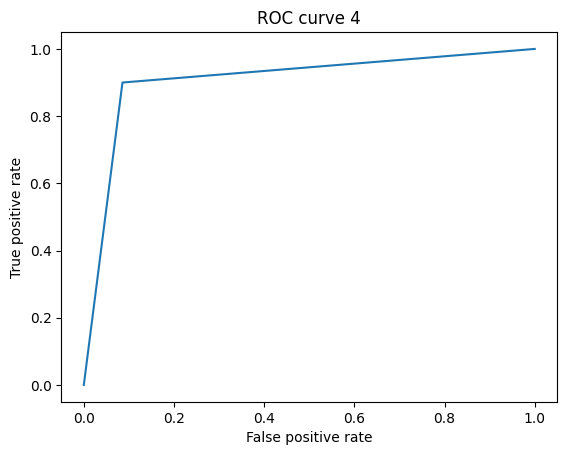

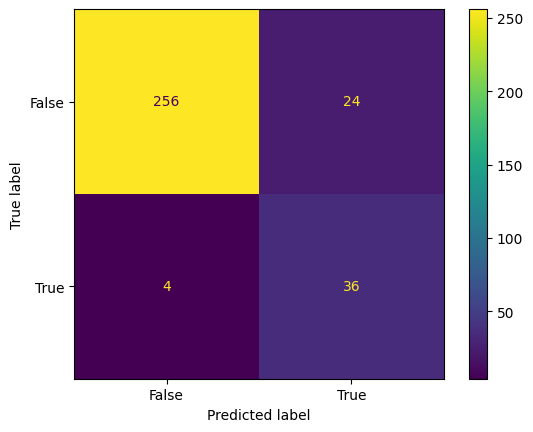

In [29]:
y_pred4 = tf.argmax(y_pred, axis=1) == 4
y_tune4 = tf.argmax(y_tune, axis=1) == 4
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_tune4, y_pred4)
auc_rf4 = metrics.auc(fpr4, tpr4)
plt.plot(fpr4, tpr4, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 4')

print("class 4 f1 score")
print(metrics.f1_score(y_tune4, y_pred4, average="macro"))
print("class 4 precision score")
print(metrics.precision_score(y_tune4, y_pred4, average="macro"))
print("class 4 recall score")
print(metrics.recall_score(y_tune4, y_pred4, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune4, y_pred4)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 5 f1 score
0.6933053284120803
class 5 precision score
0.6792303637322087
class 5 recall score
0.7125


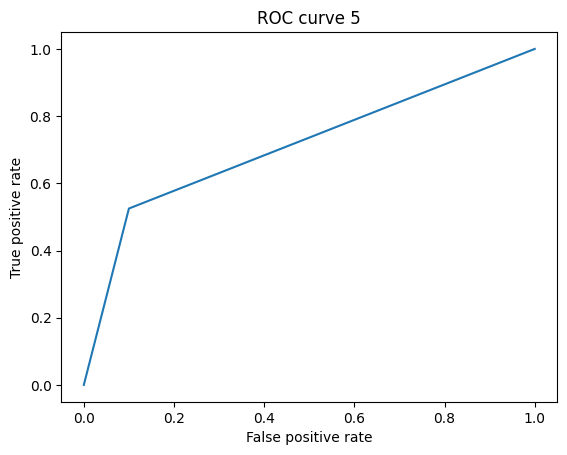

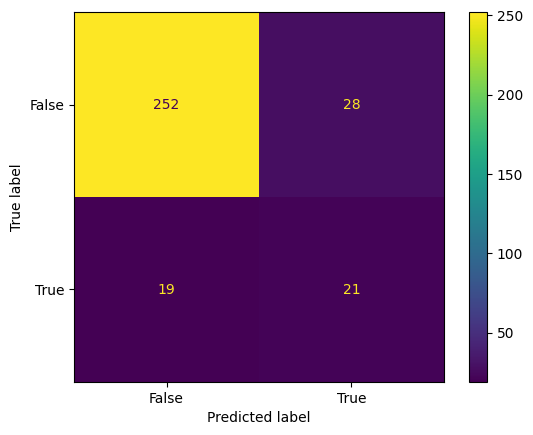

In [30]:
y_pred5 = tf.argmax(y_pred, axis=1) == 5
y_tune5 = tf.argmax(y_tune, axis=1) == 5
fpr5, tpr5, thresholds5 = metrics.roc_curve(y_tune5, y_pred5)
auc_rf5 = metrics.auc(fpr5, tpr5)
plt.plot(fpr5, tpr5, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 5')

print("class 5 f1 score")
print(metrics.f1_score(y_tune5, y_pred5, average="macro"))
print("class 5 precision score")
print(metrics.precision_score(y_tune5, y_pred5, average="macro"))
print("class 5 recall score")
print(metrics.recall_score(y_tune5, y_pred5, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune5, y_pred5)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 6 f1 score
0.6752394861258942
class 6 precision score
0.6986828887152584
class 6 recall score
0.6589285714285714


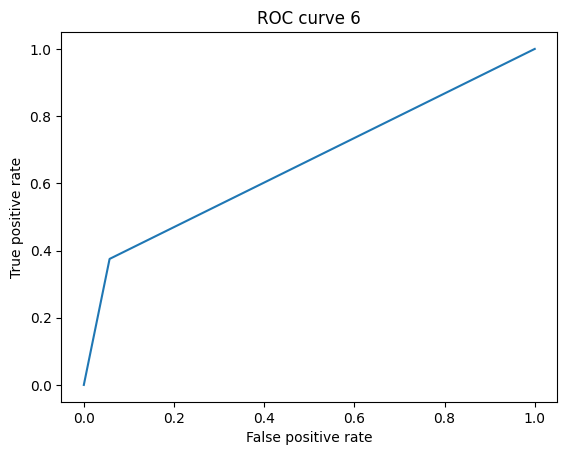

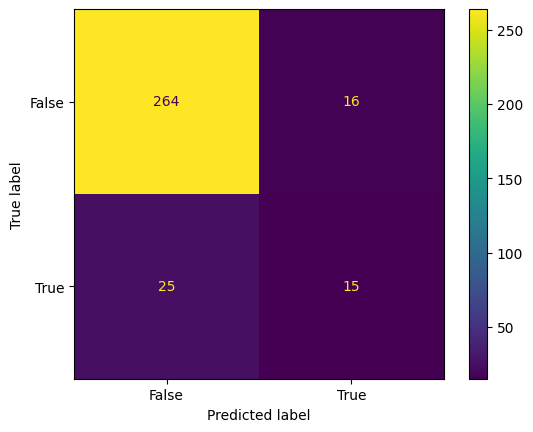

In [31]:
y_pred6 = tf.argmax(y_pred, axis=1) == 6
y_tune6 = tf.argmax(y_tune, axis=1) == 6
fpr6, tpr6, thresholds6 = metrics.roc_curve(y_tune6, y_pred6)
auc_rf6 = metrics.auc(fpr6, tpr6)
plt.plot(fpr6, tpr6, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 6')

print("class 6 f1 score")
print(metrics.f1_score(y_tune6, y_pred6, average="macro"))
print("class 6 precision score")
print(metrics.precision_score(y_tune6, y_pred6, average="macro"))
print("class 6 recall score")
print(metrics.recall_score(y_tune6, y_pred6, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune6, y_pred6)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

class 7 f1 score
0.6507525571715018
class 7 precision score
0.6777461784571632
class 7 recall score
0.6339285714285714


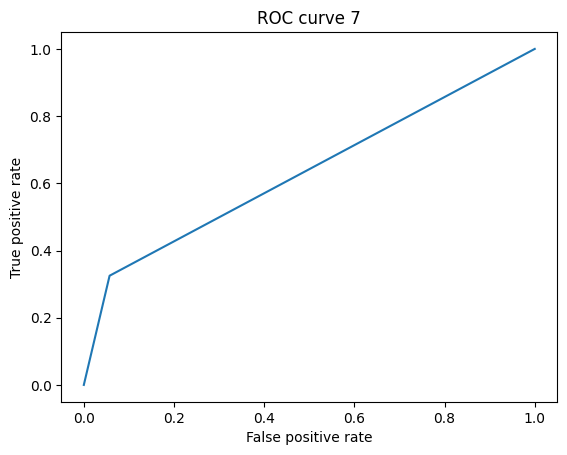

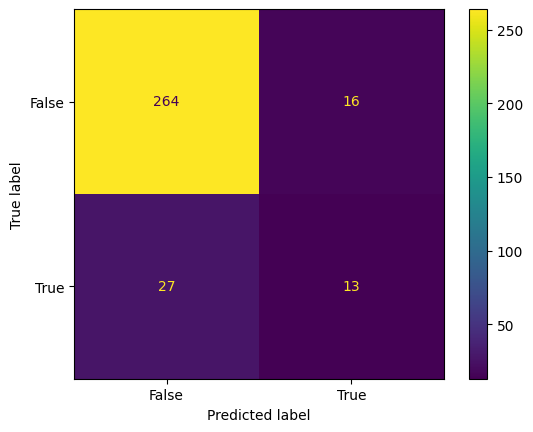

In [32]:
y_pred7 = tf.argmax(y_pred, axis=1) == 7
y_tune7 = tf.argmax(y_tune, axis=1) == 7
fpr7, tpr7, thresholds7 = metrics.roc_curve(y_tune7, y_pred7)
auc_rf7 = metrics.auc(fpr7, tpr7)
plt.plot(fpr7, tpr7, label='Keras (area = {:.3f})'.format(auc_rf1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve 7')

print("class 7 f1 score")
print(metrics.f1_score(y_tune7, y_pred7, average="macro"))
print("class 7 precision score")
print(metrics.precision_score(y_tune7, y_pred7, average="macro"))
print("class 7 recall score")
print(metrics.recall_score(y_tune7, y_pred7, average="macro"))

confusion_matrix = metrics.confusion_matrix(y_tune7, y_pred7)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()

In [33]:
n_classes = 8
fpr = [0] * 8
tpr = [0] * 8
thresholds = [0] * 8
auc_score = [0] * 8

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = metrics.roc_curve((y_tune_enc == i), (y_pred_enc == i))
    auc_score[i] = metrics.auc(fpr[i], tpr[i])

sum(auc_score) / n_classes

0.7053571428571428

Micro-averaged One-vs-Rest ROC AUC score:
0.71


Text(0.5, 1.0, 'ROC curve (AUC = 0.705)')

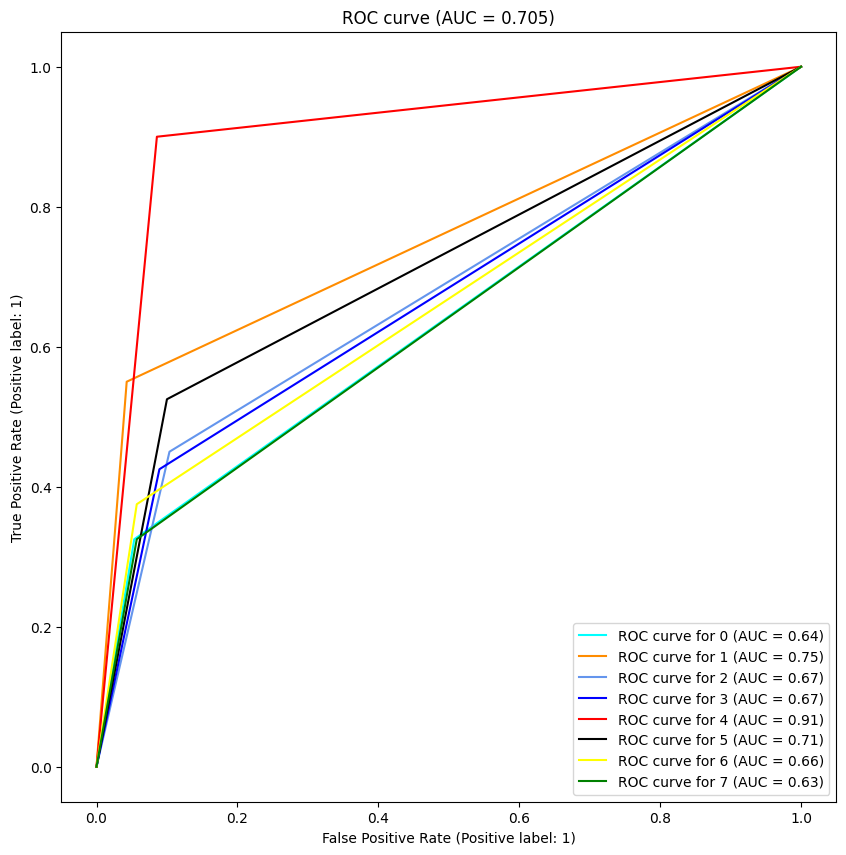

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
i = 0
colors = cycle(["aqua", "darkorange", "cornflowerblue", "blue", "red", "black", "yellow", "green"])
for class_id, color in zip(range(n_classes), colors):
    metrics.RocCurveDisplay.from_predictions(
        (y_tune_enc == i),
        (y_pred_enc == i),
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )
    i+=1


from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_tune,
    y_pred,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")
plt.title('ROC curve (AUC = {:.3f})'.format(micro_roc_auc_ovr))